In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

________________________________

In [93]:
network = 'tarbase'
network_ppi = 'preppi'
target_homology = 'mix' #'wgd', 'ssd' or 'mix'
remove_pre_2R = True

In [94]:
if target_homology == 'wgd':
	file_path_1 = f'./output/{network}_om.z_1000.{network_ppi}.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.{network_ppi}.tsv'
elif target_homology == 'ssd':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.{network_ppi}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{network_ppi}.tsv'
elif target_homology == 'mix':
	file_path_1 = f'./output/{network}_om.z_1000.{network_ppi}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{network_ppi}.tsv'
else:
	raise ValueError("target_homology must be 'wdg', 'ssd' or 'mix'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [95]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[8, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

mirna_lno_dict['MIRLET7E'][0]

'Bilateria'

In [96]:
df_wgd = df_1
df_ssd = df_2

In [97]:
print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  1383


In [98]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

if remove_pre_2R:
	df_ssd = df_ssd[~(df_ssd["miRNA_1"].apply(all_clades_in_pre2R) & df_ssd["miRNA_2"].apply(all_clades_in_pre2R))]

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  417


In [99]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd = remove_mirna_pairs(df_ssd, df_wgd)

In [100]:
print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd))

Number of WGD pairs after removing miRNA pairs from SSD:  113
Number of SSD pairs after removing miRNA pairs from SSD:  402


In [101]:
# if the column Z-score is equal to "sigma_err" and the column "n_relevant_bifan" is equal to 0, then the Z-score is equal to 0
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] != 0)
    df = df[~mask_remove]

    return df

df_wgd = remove_sigma_err(df_wgd)
df_ssd = remove_sigma_err(df_ssd)

In [102]:
df_wgd_zscores = df_wgd['Z-score'].astype(float)
df_ssd_zscores = df_ssd['Z-score'].astype(float)

In [103]:
df_wgd_nbifan = df_wgd['n_relevant_bifan'].astype(int)
df_ssd_nbifan = df_ssd['n_relevant_bifan'].astype(int)

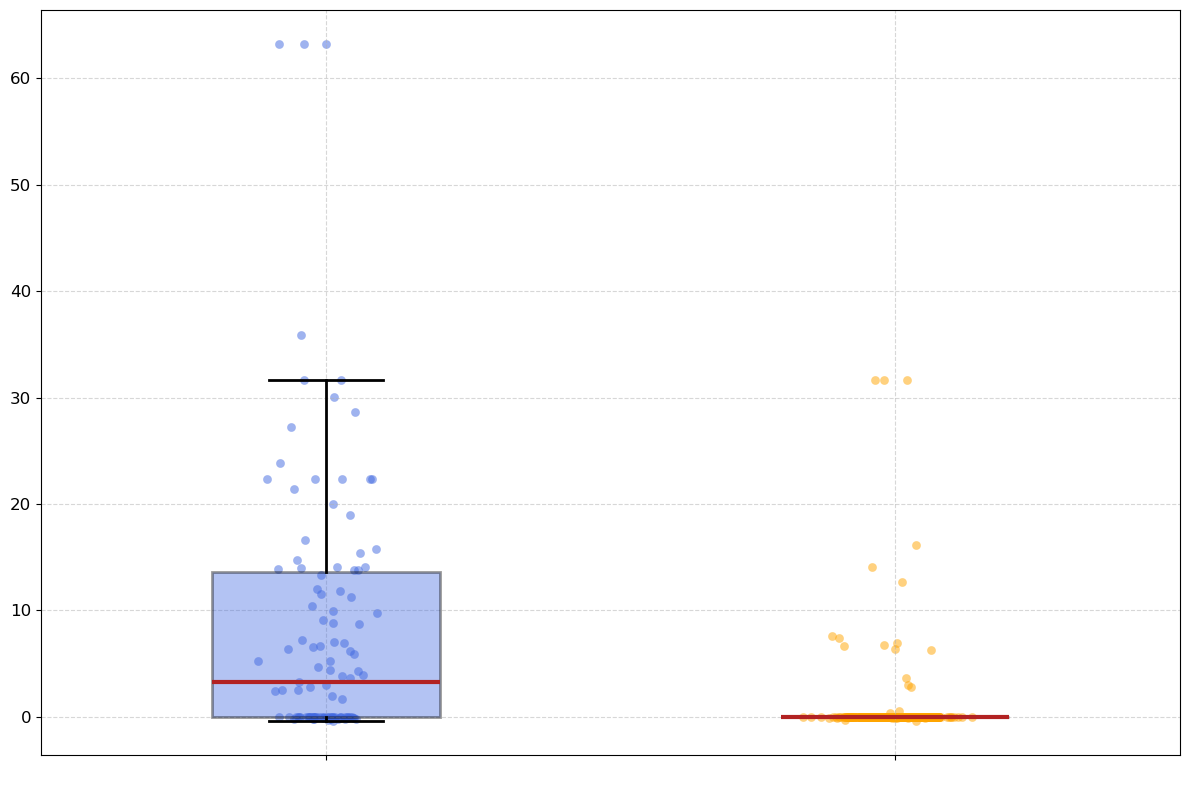

In [104]:
data = [df_wgd_zscores, df_ssd_zscores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['', ''][i])

plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_{network_ppi}_{target_homology}_ppibifan_boxplot_zscores_mgdbSSD.png', dpi=300)
plt.show()

In [105]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_zscores, df_ssd_zscores)
print(f"KS test results with parameters:\nnetwork={network}\nppi={network_ppi}\ntarget_homology={target_homology}\nremove_pre_2R={remove_pre_2R}")
print(100 * "=")
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS test results with parameters:
network=tarbase
ppi=preppi
target_homology=mix
remove_pre_2R=True
KS statistic: 0.527366562542442, p-value: 9.280142347131355e-23


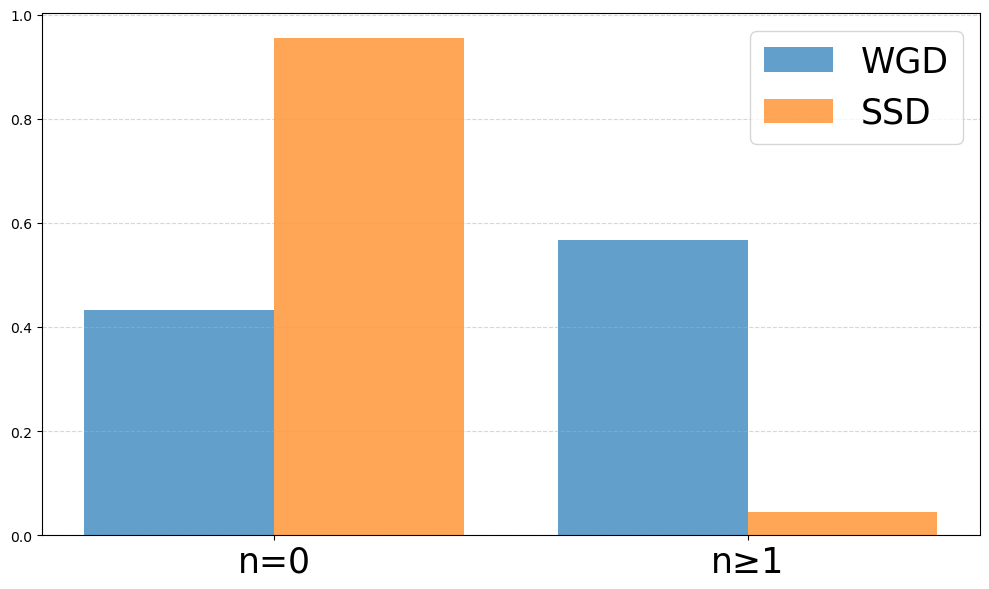

In [106]:
labels = ['n=0', 'n≥1']

def bin_bifans(count, labels=labels):
    if count == 0:
        return labels[0]
    else:
        return labels[1]

# Bin the counts
wgd_binned = pd.Series(df_wgd_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)

x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels, fontsize=25)
plt.xlabel('')
plt.title('')
plt.legend(fontsize=25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_{network_ppi}_{target_homology}_ppibifan_barplot_zscores_mgdbSSD.png', dpi=300)
plt.show()

In [107]:
print("WGD pairs with 0 relevant bifan: ", len(df_wgd[df_wgd['n_relevant_bifan'] == 0]))
print("SSD pairs with 0 relevant bifan: ", len(df_ssd[df_ssd['n_relevant_bifan'] == 0]))
print("WGD pairs with at least 1 relevant bifan: ", len(df_wgd[df_wgd['n_relevant_bifan'] > 0]))
print("SSD pairs with at least 1 relevant bifan: ", len(df_ssd[df_ssd['n_relevant_bifan'] > 0]))

WGD pairs with 0 relevant bifan:  48
SSD pairs with 0 relevant bifan:  380
WGD pairs with at least 1 relevant bifan:  63
SSD pairs with at least 1 relevant bifan:  18


In [108]:
# print the SSD pairs with Z-score > 3
df_ssd_high_z = df_ssd[df_ssd['Z-score'].astype(float) > 1]
df_ssd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
1077,MIR15A,MIR16-1,478,1213,393,0.530,0.809382,6,1,6.758238695180043,1.46844548776226e-06
1078,MIR15A,MIR16-2,478,1315,396,0.580,0.783326,6,0,6.91921158209964,2.6428654817944874e-06
1079,MIR15A,MIR195,478,411,372,0.087,0.308919,4,1,12.66674741732198,0.0
1082,MIR15A,MIR503,478,179,134,0.017,0.129271,1,17,7.604178417933438,0.0
1083,MIR15B,MIR16-1,443,1213,376,0.450,0.689565,5,0,6.598361967332901,5.007261076883651e-07
1084,MIR15B,MIR16-2,443,1315,379,0.456,0.718376,5,1,6.325378827594547,5.465140566762727e-07
1085,MIR15B,MIR195,443,411,373,0.055,0.244898,4,0,16.108751398329172,0.0
1088,MIR15B,MIR503,443,179,130,0.016,0.133207,1,15,7.387021006519912,0.0
1091,MIR16-1,MIR424,1213,560,281,0.625,0.840461,3,31,2.8258294948740557,0.025656930899025543
1095,MIR16-2,MIR424,1315,560,290,0.705,0.918681,4,16,3.5866634556255956,0.005896566924389113


In [109]:
df_wgd_high_z = df_wgd[df_wgd['Z-score'].astype(float) > 3]
df_wgd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
1,MIR103A1,MIR103A2,950,1075,950,0.703,0.837133,13,0,14.689429024878699,1.9984014443252818e-15
2,MIR103A1,MIR107,950,959,927,0.626,0.819832,12,0,13.873579343331992,9.103828801926284e-15
3,MIR103A2,MIR107,1075,959,930,0.704,0.846395,12,0,13.346019188062533,4.374278717023117e-14
4,MIR106A,MIR106B,538,398,205,0.035,0.183780,1,35,5.250850271282601,2.477684724055962e-12
5,MIR106A,MIR17,538,1373,308,0.378,0.609193,3,5,4.304055353552772,4.7000632797722375e-05
8,MIR124-1,MIR124-3,170,170,170,0.001,0.031607,2,0,63.24556111697485,0.0
9,MIR124-1,MIR124-2,170,170,170,0.001,0.031607,2,0,63.24556111697485,0.0
10,MIR124-3,MIR124-2,170,170,170,0.001,0.031607,2,0,63.24556111697485,0.0
14,MIR128-1,MIR128-2,207,207,207,0.002,0.044677,1,2,22.338307903688676,0.0
19,MIR133A1,MIR133A2,119,119,119,0.001,0.031607,1,1,31.606961258558215,0.0
